In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
import tree
import scipy
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from omegaconf import OmegaConf
import importlib
import logging
import sys

from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from data import r3_diffuser_ddpm
from data import digs_data_loader
from model import loss
from experiments import train_se3_diffusion
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
# Enable logging
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [2]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/home/btrippe/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

In [3]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0

diff_conf = conf.diffuser
diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

In [4]:
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
se3_diff = exp.diffuser
r3_diff = se3_diff._r3_diffuser
so3_diff = se3_diff._so3_diffuser

# Extract a protein backbone.
train_iter = iter(train_loader)
next_item = next(train_iter)
res_mask = next_item['res_mask'][0, :]
ca_pos = next_item['xyz'][0, :, 1, :][res_mask.bool()]


INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


In [5]:
# SDE time parameters
num_t = 10
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t

## Score analysis of SO(3) diffuser

In [6]:
# Simulate score of marginals
rot_0 = np.zeros((1, 3))
marginal_samples = {}
marginal_scores = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    marginal_scores[i] = []
    for _ in range(500):
        rot_t, score_t, score_norm_t = so3_diff.forward_marginal(rot_0, t)
        marginal_samples[i].append(rot_t)
        marginal_scores[i].append(score_t)

In [7]:
# Print sample average
for i,t in enumerate(forward_t):
    score_norm_t = so3_diff.exp_score_norm(t)
    scores_t = marginal_scores[i]
    avg_score_t = np.mean(np.linalg.norm(np.stack(scores_t)[:, 0, :], axis=-1))
    print(f'index={i}, t={t:2.4f}, Sample average IGSO(3)={avg_score_t:2.2f}, exp_score_norm={score_norm_t:2.2f}')


index=0, t=0.0000, Sample average IGSO(3)=16.14, exp_score_norm=15.94
index=1, t=0.1111, Sample average IGSO(3)=13.36, exp_score_norm=13.48
index=2, t=0.2222, Sample average IGSO(3)=9.27, exp_score_norm=9.28
index=3, t=0.3333, Sample average IGSO(3)=6.04, exp_score_norm=6.13
index=4, t=0.4445, Sample average IGSO(3)=4.13, exp_score_norm=4.14
index=5, t=0.5556, Sample average IGSO(3)=2.92, exp_score_norm=2.87
index=6, t=0.6667, Sample average IGSO(3)=2.09, exp_score_norm=2.05
index=7, t=0.7778, Sample average IGSO(3)=1.44, exp_score_norm=1.44
index=8, t=0.8889, Sample average IGSO(3)=0.85, exp_score_norm=0.86
index=9, t=1.0000, Sample average IGSO(3)=0.40, exp_score_norm=0.40


## Score analysis of R(3) diffuser

In [8]:
# Simulate score of marginals
rot_0 = np.zeros((1, 3))
marginal_samples = {}
marginal_scores = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    marginal_scores[i] = []
    for _ in range(500):
        x_t, score_t = r3_diff.forward_marginal(rot_0, t, score_norm=False)
        marginal_samples[i].append(x_t)
        marginal_scores[i].append(score_t)

In [9]:
# Simulate score of marginals
rot_0 = np.zeros((1000, 3))
discrete_t = np.linspace(1e-5, 1, 1000)
exp_score_norms = []
for i,t in enumerate(discrete_t):
    _, score_t = r3_diff.forward_marginal(rot_0, t, score_norm=False)
    scores_norm_t = np.linalg.norm(score_t, axis=-1)
    exp_score_norms.append(np.mean(scores_norm_t))

In [10]:
# Print sample average
for i,t in enumerate(forward_t):
    scores_t = marginal_scores[i]
    score_norm_t = exp_score_norms[min(np.sum(discrete_t <= t), 999)]
    avg_score_t = np.mean(np.linalg.norm(np.stack(scores_t)[:, 0, :], axis=-1))
#     print(f'index={i}, t={t:2.7f}, Sample average R(3)={avg_score_t:2.2f}')
    print(f'index={i}, t={t:2.4f}, Sample average R(3)={avg_score_t:2.2f}, exp_score_norm={score_norm_t:2.2f}')


index=0, t=0.0000, Sample average R(3)=1634.35, exp_score_norm=153.41
index=1, t=0.1111, Sample average R(3)=4.48, exp_score_norm=4.41
index=2, t=0.2222, Sample average R(3)=2.56, exp_score_norm=2.51
index=3, t=0.3333, Sample average R(3)=1.94, exp_score_norm=1.93
index=4, t=0.4445, Sample average R(3)=1.73, exp_score_norm=1.72
index=5, t=0.5556, Sample average R(3)=1.63, exp_score_norm=1.66
index=6, t=0.6667, Sample average R(3)=1.65, exp_score_norm=1.59
index=7, t=0.7778, Sample average R(3)=1.58, exp_score_norm=1.57
index=8, t=0.8889, Sample average R(3)=1.56, exp_score_norm=1.60
index=9, t=1.0000, Sample average R(3)=1.61, exp_score_norm=1.58


## Analyze schedule

In [11]:
wd = scipy.stats.wasserstein_distance

In [12]:
# SDE time parameters
num_t = 1000
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t
n_samples = 1000

In [13]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/home/btrippe/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

### Analyze translation schedule

In [14]:
# Load config.
def base_conf():
    conf = OmegaConf.load('../config/base.yaml')

    # Redirect cache from notebook directory.
    exp_conf = conf.experiment
    exp_conf.data_location = 'digs'

    data_conf = conf.data
    data_conf.digs.filtering.subset = 1
    data_conf.digs.fraction_fb = 0.0
    return conf



In [15]:
def wd_schedule(schedule):
    conf = base_conf()
    diff_conf = conf.diffuser
    diff_conf.trans_schedule = schedule
    exp = train_se3_diffusion.Experiment(conf=conf)
    train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
    r3_diff = exp.diffuser._r3_diffuser
    
    x_0 = np.zeros((n_samples, 3))
    x_1 = r3_diff.sample_ref(n_samples=n_samples)
    x_1_norm = np.linalg.norm(x_1, axis=-1)
    all_trans_wd = []
    for i,t in enumerate(forward_t):
        x_t, _ = r3_diff.forward_marginal(x_0, t, score_norm=False)
        x_t_norm = np.linalg.norm(x_t, axis=-1)
        wd_t = wd(x_t_norm, x_1_norm)
        all_trans_wd.append(wd_t)
    return all_trans_wd

In [16]:
schedule = 'linear'
conf = base_conf()
diff_conf = conf.diffuser
diff_conf.trans_schedule = schedule
exp = train_se3_diffusion.Experiment(conf=conf)

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.


In [17]:
r3_diff = exp.diffuser._r3_diffuser
r3_diff.min_b, r3_diff.max_b

(0.1, 20)

In [18]:
# cosine_wd = wd_schedule('cosine')
linear_wd = wd_schedule('linear')
exponential_wd = wd_schedule('exponential')

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


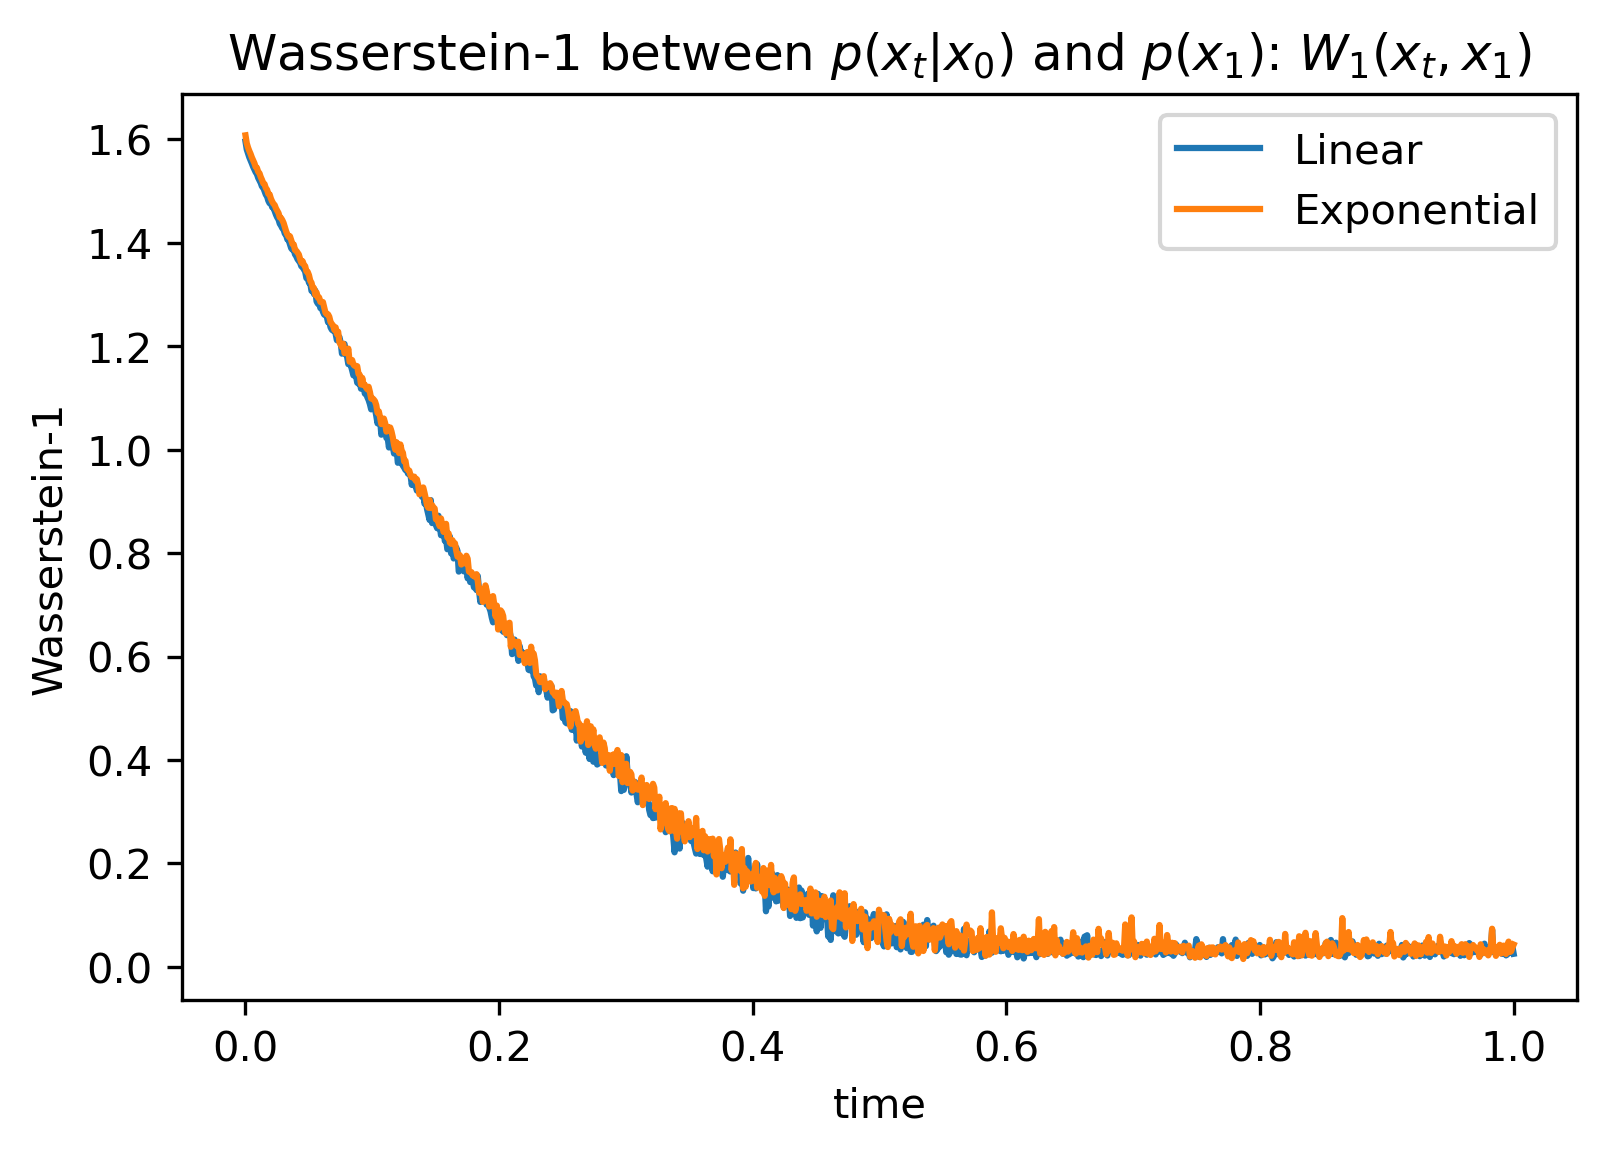

In [19]:
# plt.plot(forward_t, cosine_wd, label='Cosine')
plt.plot(forward_t, linear_wd, label='Linear')
plt.plot(forward_t, exponential_wd, label='Exponential')
plt.xlabel('time')
plt.ylabel('Wasserstein-1')
plt.title('Wasserstein-1 between $p(x_t|x_0)$ and $p(x_1)$: $W_1(x_t, x_1)$')
plt.legend()

In [20]:
# Verify the DDPM matches the parameters for the VP-SDE.
ddpm_diff = r3_diffuser_ddpm.Diffuser(
    num_b=num_t,
    min_b=0.0001,
    max_b=0.02,
    schedule='linear'
)

x_0 = np.zeros((n_samples, 3))
x_1 = r3_diff.sample_ref(n_samples=n_samples)
x_1_norm = np.linalg.norm(x_1, axis=-1)
all_ddpm_wd = []
for i,t in enumerate(forward_t):
    x_t, _, _ = ddpm_diff.forward_sample(x_0, i)
    x_t_norm = np.linalg.norm(x_t, axis=-1)
    wd_t = wd(x_t_norm, x_1_norm)
    all_ddpm_wd.append(wd_t)

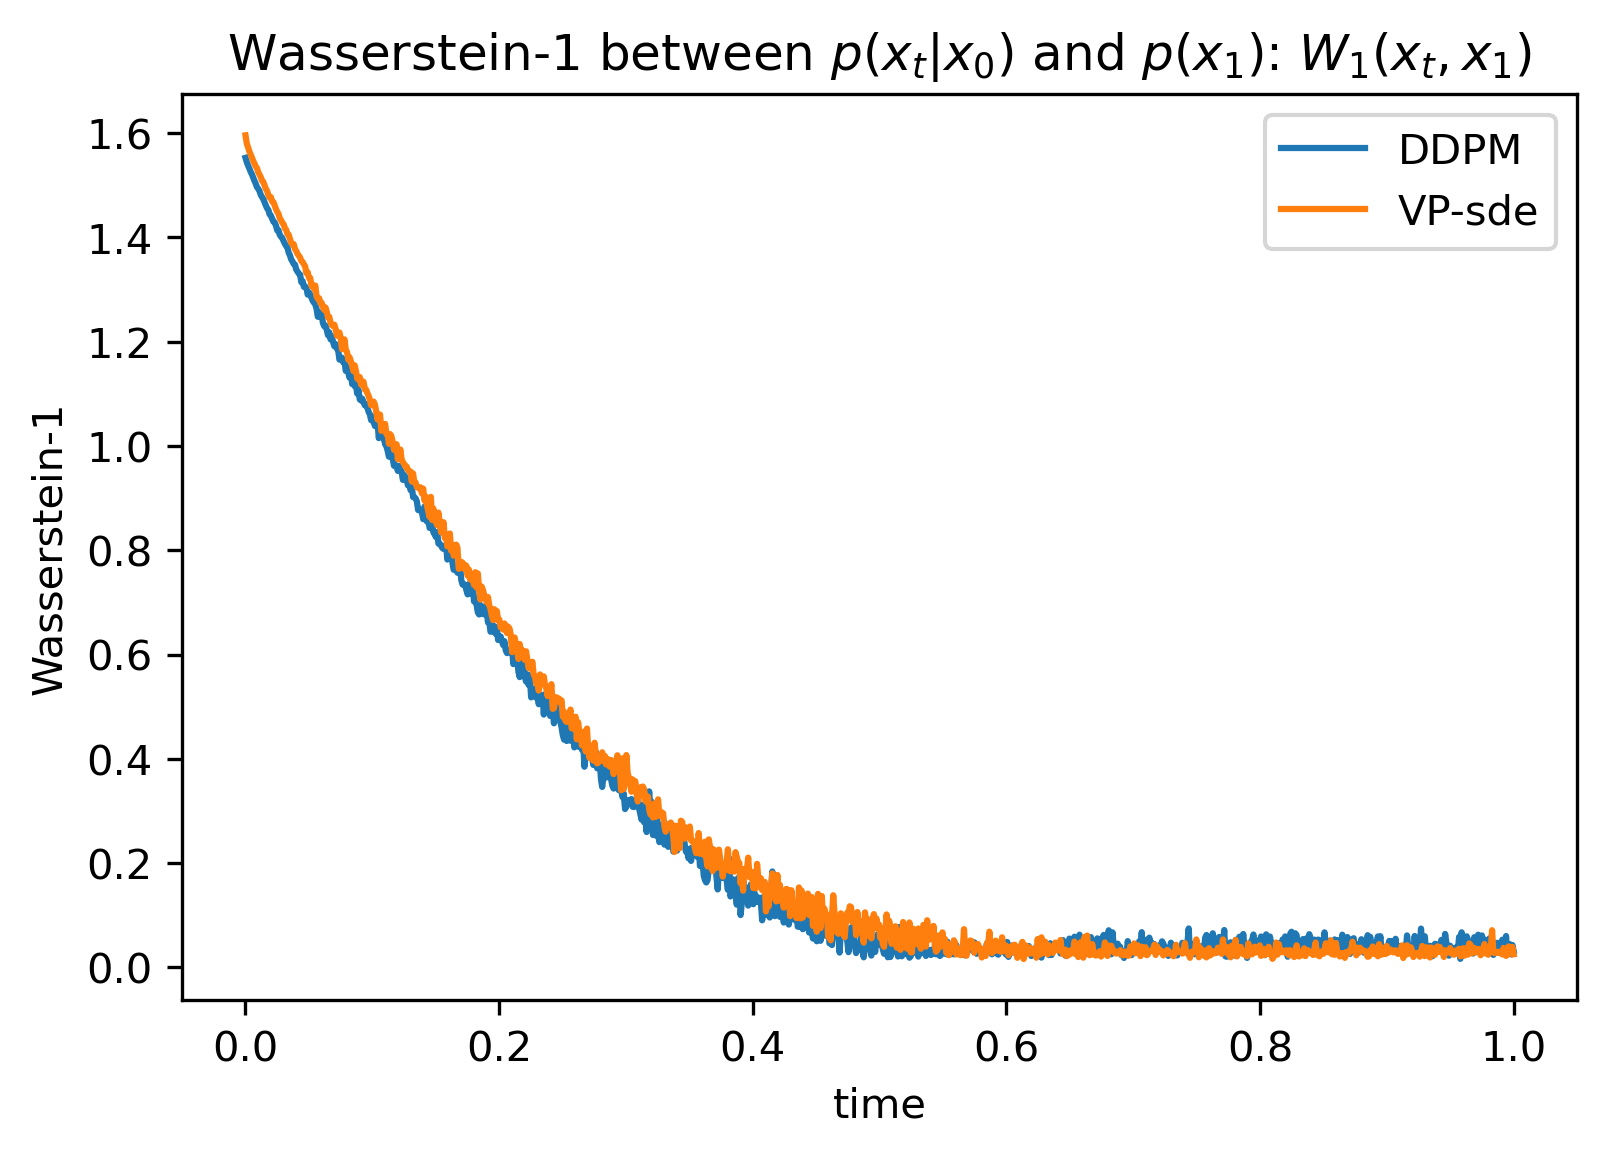

In [21]:
plt.plot(forward_t, all_ddpm_wd, label='DDPM')
plt.plot(forward_t, linear_wd, label='VP-sde')
plt.xlabel('time')
plt.ylabel('Wasserstein-1')
plt.title('Wasserstein-1 between $p(x_t|x_0)$ and $p(x_1)$: $W_1(x_t, x_1)$')
plt.legend()

### Analyze Rotation and translation

In [22]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0

diff_conf = conf.diffuser
diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'
diff_conf.trans_min_b = 0.1
diff_conf.trans_max_b = 25

In [23]:
conf = base_conf()
conf.diffuser.rot_min_sigma = 0.05
conf.diffuser.rot_min_b = 0.01
conf.diffuser.rot_max_b = 1.0
conf.diffuser.rot_schedule = "linear"

In [24]:
conf.diffuser.rot_max_sigma = 3
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
r3_diff = exp.diffuser._r3_diffuser
so3_diff = exp.diffuser._so3_diffuser

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


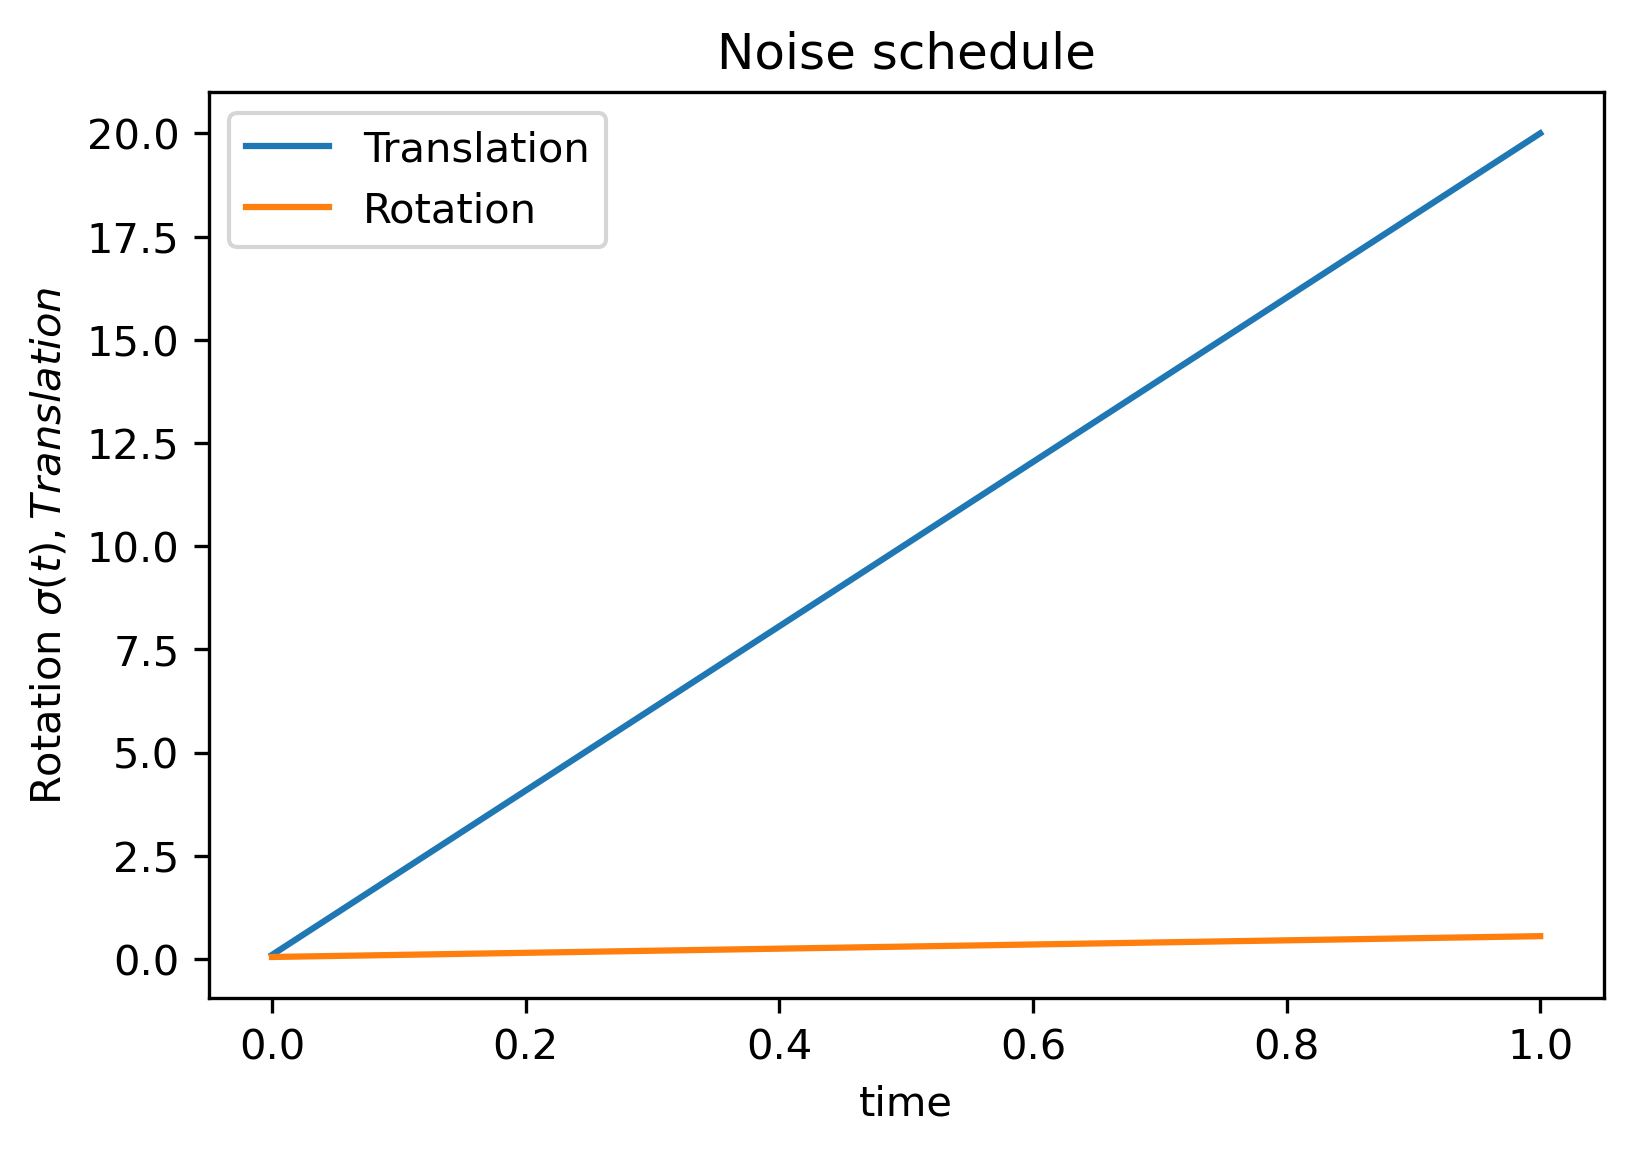

In [25]:
# Plot noise schedules
plt.plot(forward_t, r3_diff.b_t(forward_t), label='Translation')
plt.plot(forward_t, so3_diff.discrete_sigma[:-1], label='Rotation')
plt.xlabel('time')
plt.ylabel('Rotation $\sigma(t), Translation \beta(t)$')
plt.title('Noise schedule')
plt.legend()

In [26]:
so3_diff.sigma(0.), so3_diff.sigma(0.75), so3_diff.sigma(1.0)

(tensor(0.0500), tensor(0.3359), tensor(0.5550))

In [27]:
so3_diff.sigma(0.75)

tensor(0.3359)

In [28]:
# Plot wasserstein divergences
n_samples =2500
rot_0 = np.zeros((n_samples, 3))
rot_1 = so3_diff.sample_ref(n_samples=n_samples)
rot_1_norm = np.linalg.norm(rot_1, axis=-1)
all_rot_wd = []
for i,t in enumerate(forward_t):
    rot_t, _, _ = so3_diff.forward_marginal(rot_0, t)
    rot_t_norm = np.linalg.norm(rot_t, axis=-1)
    wd_t = wd(rot_t_norm, rot_1_norm)
    all_rot_wd.append(wd_t)
    
x_0 = np.zeros((n_samples, 3))
x_1 = r3_diff.sample_ref(n_samples=n_samples)
x_1_norm = np.linalg.norm(x_1, axis=-1)
all_trans_wd = []
for i,t in enumerate(forward_t):
    x_t, _ = r3_diff.forward_marginal(x_0, t, score_norm=False)
    x_t_norm = np.linalg.norm(x_t, axis=-1)
    wd_t = wd(x_t_norm, x_1_norm)
    all_trans_wd.append(wd_t)

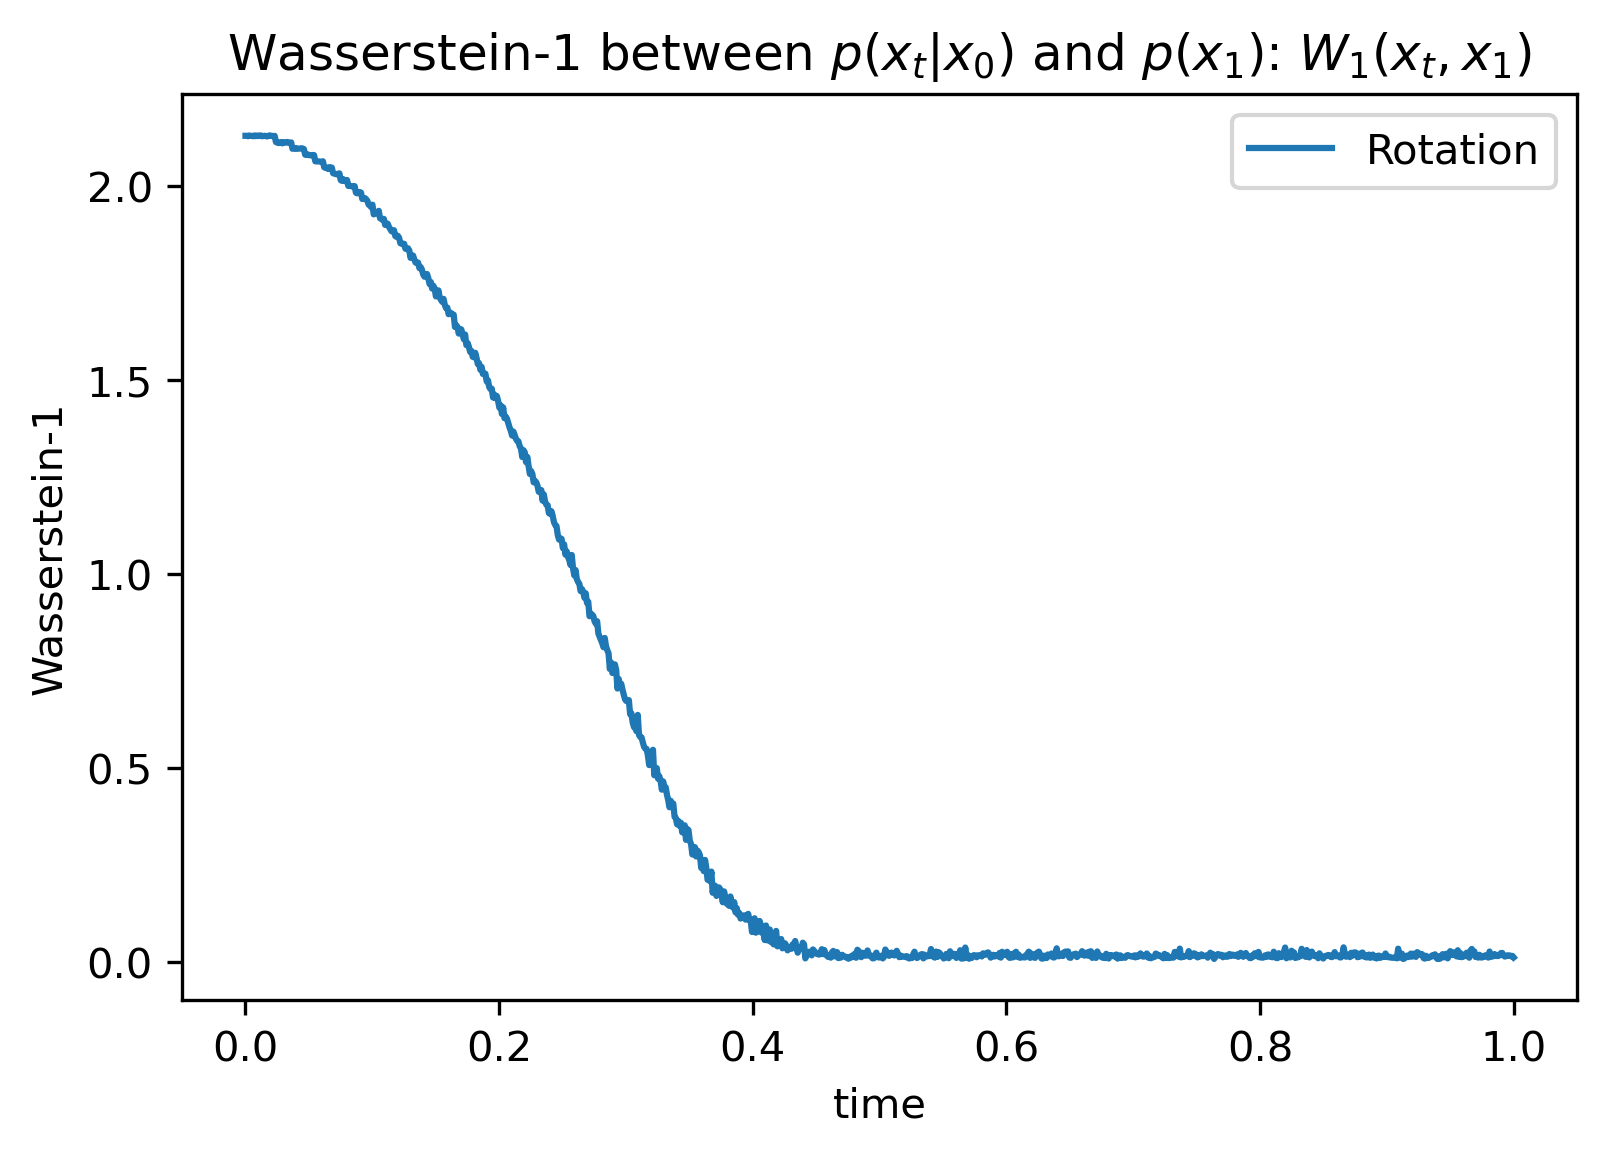

In [29]:
plt.plot(forward_t, all_rot_wd, label='Rotation')
plt.xlabel('time')
plt.ylabel('Wasserstein-1')
plt.title('Wasserstein-1 between $p(x_t|x_0)$ and $p(x_1)$: $W_1(x_t, x_1)$')
plt.legend()

t=0.0
t=0.2
t=0.3
t=0.4
t=0.5
t=1.0


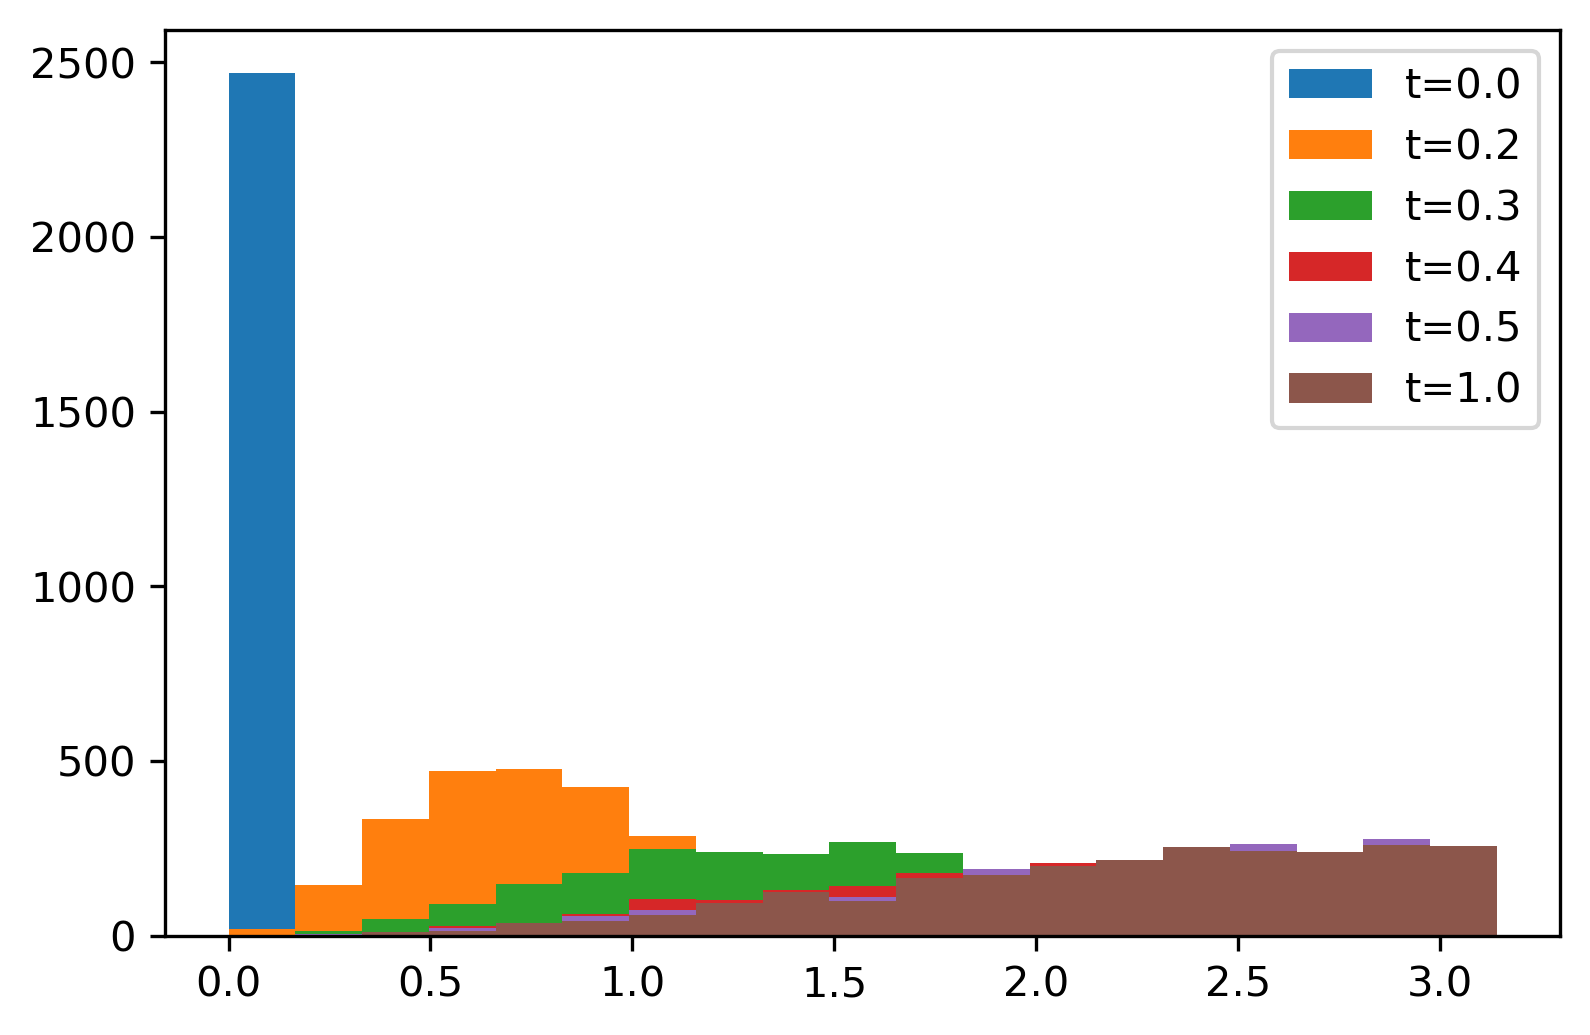

In [30]:
bins = np.linspace(0, np.pi, 20)
for t in [0.0, 0.2,0.3, 0.4, 0.5, 1.0]:
    print(f"t={t}")#", sigma={so3_diff.sigma(t)}")
    rot_t, _, _ = so3_diff.forward_marginal(rot_0, t)
    rot_t_norm = np.linalg.norm(rot_t, axis=-1)
    plt.hist(rot_t_norm, label=f"t={t}", bins=bins)
plt.legend()
plt.show()